# Preprocesamiento de datos
*(Etapa: Data Lake -> Data Pipeline + Feature engineering)*


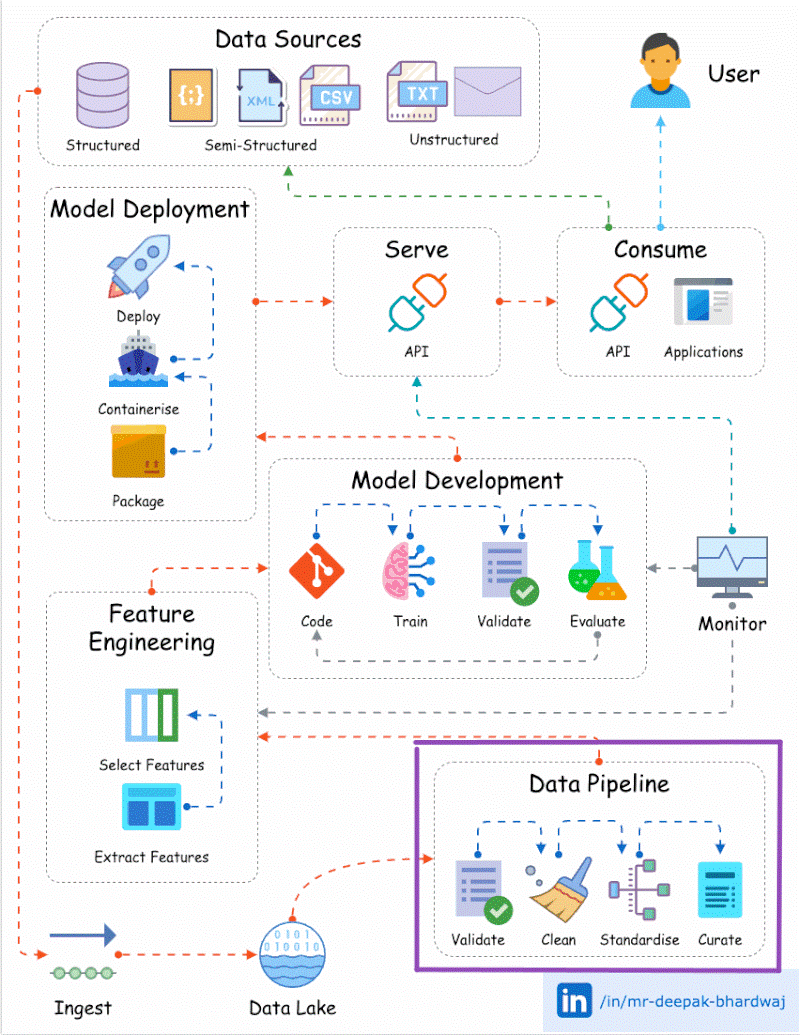

In [1]:
# Bibliotecas

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency

In [16]:
# Definiciones globales

%run ../Lib/pandas_options.py
%run ../Lib/define_constantes.py

In [3]:
# Cargar datos de tramos calificados

archivo_tramos_calificados = f'{DIRECTORIO_DATOS_PREPROCESADOS}/TRAMOSCALIFICADOS.csv'
df_tramos_calificados = pd.read_csv(archivo_tramos_calificados, low_memory=False)



---


# Analítica de datos

In [4]:
# Revisar datos cargados

print(df_tramos_calificados.info())
print(df_tramos_calificados.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   G3E_FID                      25000 non-null  int64  
 1   DIAMETRO                     25000 non-null  int64  
 2   CAMARA_CAIDA                 25000 non-null  object 
 3   CONEXIONES_ERRADAS           25000 non-null  object 
 4   MATERIAL                     25000 non-null  object 
 5   TUBERIA_ELEVADA              25000 non-null  object 
 6   VIDA_UTIL                    24645 non-null  float64
 7   FABRICANTE                   24988 non-null  object 
 8   TIPO_CIMENTACION             12400 non-null  object 
 9   TIPO_SUELO                   11838 non-null  object 
 10  TIPO_RED                     25000 non-null  object 
 11  PROF_BATEA_ENTRADA           24983 non-null  float64
 12  PROF_BATEA_SALIDA            24960 non-null  float64
 13  COTA_BATEA_ABAJO

## Procedimientos para visualización de estadísticas

In [5]:
# ------------------------------------------------------------------------------------------------------------------------
def visualizar_distribucion(lista_columnas, df, titulo='Distribuciones'):
    sns.set(style='whitegrid')
    fig, axes = plt.subplots(2, len(lista_columnas), figsize=(16, 8))

    for i, columna in enumerate(lista_columnas):
        if df[columna].dtype == bool:
            sns.countplot(x=columna, data=df, ax=axes[0, i])
            axes[0, i].set_xlabel(columna, fontsize=10, fontweight='bold')
            axes[0, i].set_ylabel('Cantidad' if i == 0 else '', fontsize=10, fontweight='bold')
            axes[0, i].tick_params(labelsize=8)
        else:
            sns.boxplot(x=df[columna], ax=axes[0, i])
            axes[0, i].set_xlabel(columna, fontsize=10, fontweight='bold')
            axes[0, i].set_ylabel('Valores' if i == 0 else '', fontsize=10, fontweight='bold')
            axes[0, i].tick_params(labelsize=8)


        sns.histplot(data=df, x=columna, kde=True, ax=axes[1, i])
        axes[1, i].set_xlabel('')
        axes[1, i].set_ylabel('Frecuencia' if i == 0 else '', fontsize=10, fontweight='bold')
        axes[1, i].tick_params(labelsize=8)

    fig.suptitle(titulo, fontsize=12, fontweight='bold')
    fig.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------------------------------------------------
def visualizar_correlaciones(lista_columnas, df, titulo='Matriz de correlaciones'):
    matriz_correlaciones = df[lista_columnas].corr()

    plt.figure(figsize=(14, 4))
    sns.set(font_scale=1)

    mascara = np.triu(np.ones(matriz_correlaciones.shape), k=1) # Ocultar diagonal superior
    mapa = sns.heatmap(matriz_correlaciones, annot=True, cmap='seismic', center=0, vmin=-1, vmax=1, mask=mascara, linewidths=0)
    mapa.set_facecolor('none')

    plt.title(titulo, fontsize=12, fontweight='bold')
    plt.show()

# ----------------------------------------------------------------------------------------------------------------------
def visualizar_matriz_dispersion(lista_columnas, df, nombre_columna_clasificadora, titulo='Matriz de dispersión'):
    tipo_versus = df[nombre_columna_clasificadora].dtype
    paleta = {False: 'lightgreen', True: 'red'} if tipo_versus == bool else {0: 'black', 1: 'lightgreen', 2: 'lightblue', 3: 'yellow', 4: 'orange', 5: 'red'}

    malla = sns.pairplot(
        df,
        vars=lista_columnas,
        hue=nombre_columna_clasificadora,
        palette=paleta,
    )

    malla.fig.suptitle(titulo, y=1.02, fontsize=12, fontweight='bold')
    malla.fig.set_facecolor('lightgray')
    plt.show()

# ---------------------------------------------------------------------------------------------------------------------
def visualizar_distribucion_categoricas(lista_columnas, nombre_col_comparacion, df, titulo=''):
    fig, axes = plt.subplots(nrows=int(len(lista_columnas) / 2 + 0.5), ncols=2, figsize=(14, 2 * len(lista_columnas)))
    axes = axes.flat

    tipo_versus = df[nombre_col_comparacion].dtype
    paleta = {False: 'lightgreen', True: 'red'} if tipo_versus == bool else {0: 'black', 1: 'lightgreen', 2: 'lightblue', 3: 'yellow', 4: 'orange', 5: 'red'}

    for i, columna in enumerate(lista_columnas):
        tabla = pd.crosstab(df[columna], df[nombre_col_comparacion])
        sums = tabla.sum(axis=1)
        sorted_indices = sums.sort_values().index
        tabla.loc[sorted_indices].plot(
            kind='barh',
            stacked=True,
            ax=axes[i],
            color=[paleta[col] for col in tabla.columns],
            legend=False
        )
        axes[i].set_title(f'{nombre_col_comparacion} vs {columna}', fontsize=10, fontweight='bold')
        axes[i].tick_params(labelsize=8)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    # Eliminar el último eje si hay un número impar de columnas
    if len(lista_columnas) % 2 != 0:
        fig.delaxes(axes[-1])

    fig.suptitle(titulo, y=1.02, fontsize=12, fontweight='bold')
    fig.tight_layout()
    etiquetas = [f"{k}" for k in paleta.keys()]
    fig.legend(etiquetas, title=nombre_col_comparacion, loc='center right', bbox_to_anchor=(1.1, 0.5))
    plt.show()

# ---------------------------------------------------------------------------------------------------------------------
def visualizar_correlaciones_categoricas(lista_columnas, df, alpha=0.001, titulo=''):
    matriz = []
    for i, c1 in enumerate(lista_columnas):
        matriz.append([])
        for j, c2 in enumerate(lista_columnas):
            p = chi2_contingency(pd.crosstab(df[c1], df[c2])).pvalue if i != j else 0
            matriz[i].append(p)

    plt.figure(figsize=(15, 5))
    sns.set(font_scale=0.8)
    mascara = np.triu(np.ones(len(lista_columnas)), k=1) # Ocultar diagonal superior
    mapa = sns.heatmap(
        matriz,
        xticklabels=lista_columnas,
        yticklabels=lista_columnas,
        annot=True,
        fmt=".3e",
        mask=mascara,
        cmap="rocket_r",
        vmax=alpha,
    )

    mapa.set_facecolor('none')
    plt.title(titulo, fontsize=12, fontweight='bold')
    plt.show()



# Análisis exploratorio

## Variables numéricas:

Conclusiones:

*   DIAMETRO: Entre 100 mm y 2000 mm, y convertir a metros para unificar unidades
*   LONGITUD: Entre 1 mt y 250 mt
*   PROF_BATEA, PROF_BATE1: <= 150 mt
*   PENDIENTE: Recalcular con PROF_BATEA, PROF_BATE1 Y LONGITUD
*   EDAD: 0-100 años
*   Normalizar valores numéricos entre 0-1
*   AREA: Categoría nueva, calculada como DIAMETRO x LONGITUD x PI

*   LONGITUD_AGUAS_ARRIBA: Campo nuevo incluido. Calcula la longitud aguas a arriba de las tuberías en la red.






In [6]:
# Intentar convertir la columna FECHA_INSTALACION a formato de fecha
df_tramos_calificados['FECHA_INSTALACION'] = pd.to_datetime(df_tramos_calificados['FECHA_INSTALACION'], errors='coerce')

In [10]:
# Crear temporalmente característica EDAD para el análisis exploratorio de variables numéricas

df_tramos_calificados_con_edad = df_tramos_calificados.assign(
    EDAD=df_tramos_calificados['FECHA_INSTALACION'].apply(
        lambda fecha: (datetime.now() - pd.to_datetime(fecha)).total_seconds() / (365 * 24 * 60 * 60)
    )
)

numericas_a_explorar = ['EDAD', 'DIAMETRO', 'LONGITUD', 'PROF_BATEA_ENTRADA', 'PROF_BATEA_SALIDA', 'PENDIENTE', 'CALIFICACION', 'LONGITUD_AGUAS_ARRIBA']

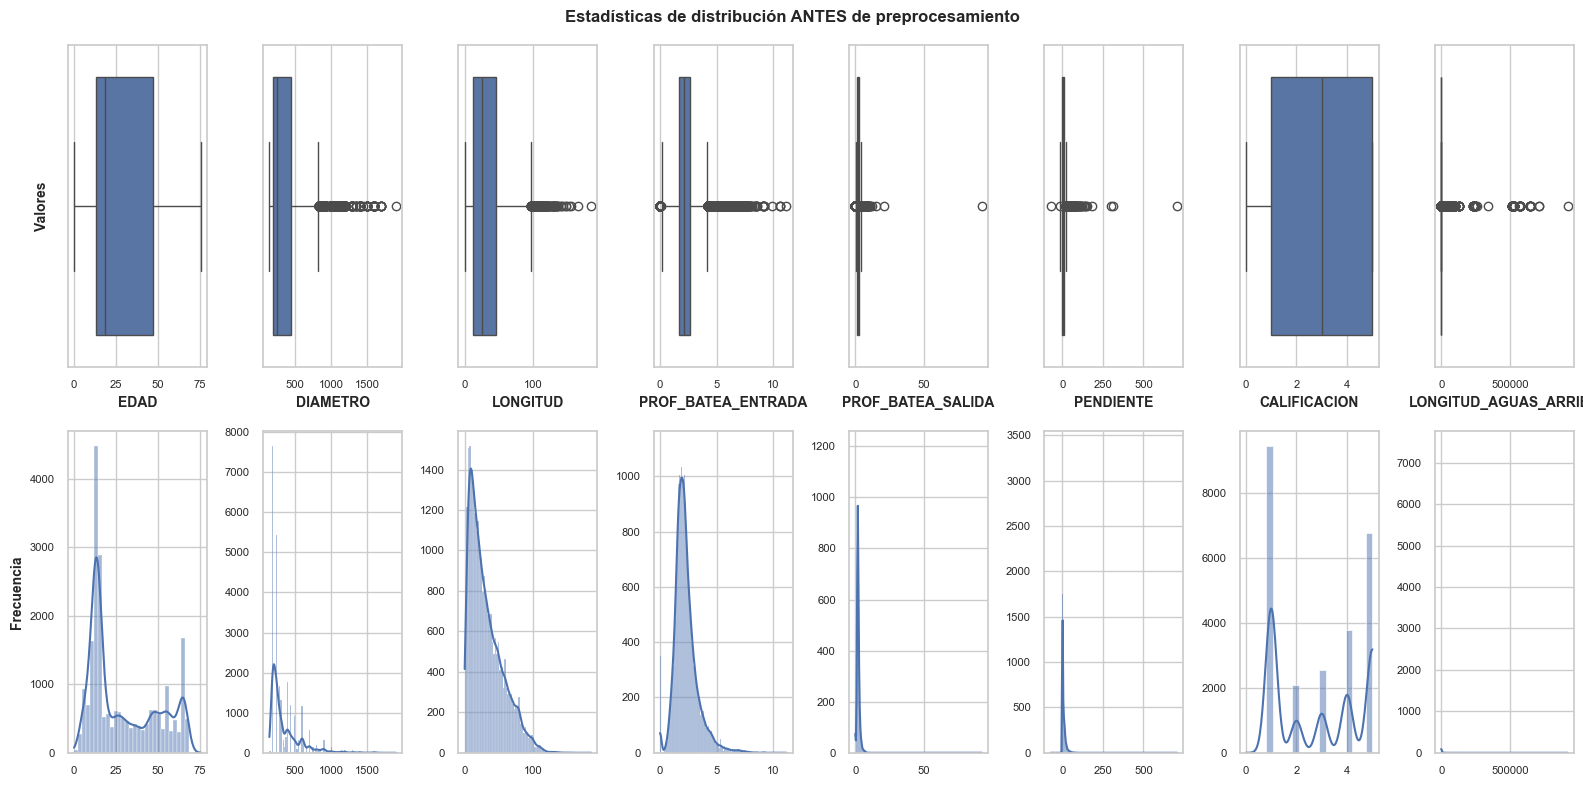

In [11]:
visualizar_distribucion(
    numericas_a_explorar,
    df_tramos_calificados_con_edad,
    titulo='Estadísticas de distribución ANTES de preprocesamiento'
)

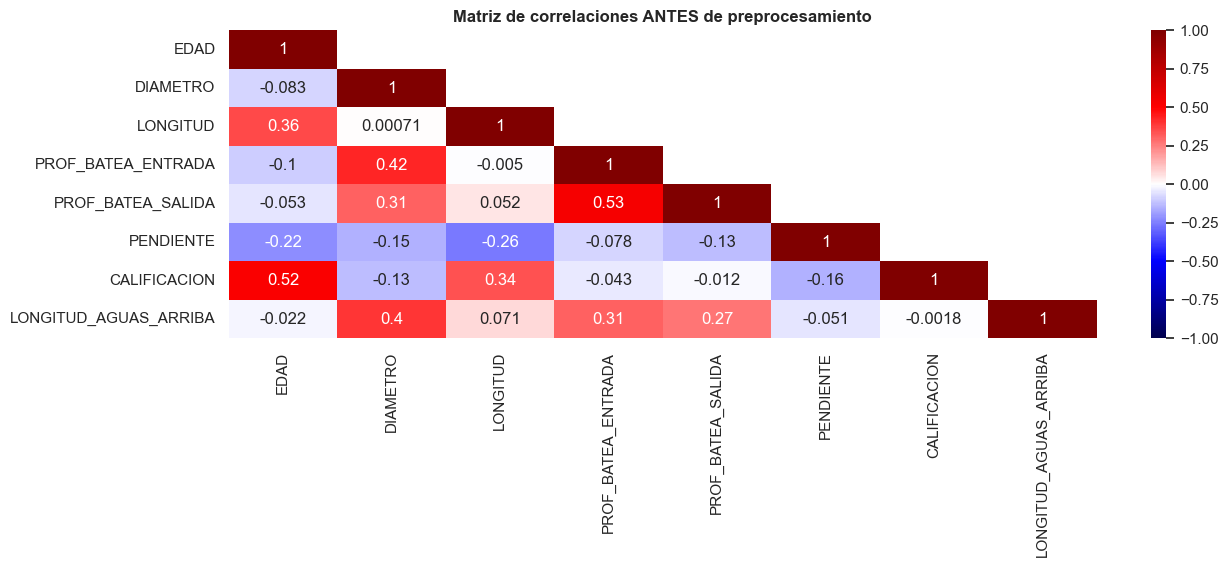

In [12]:
visualizar_correlaciones(
    numericas_a_explorar,
    df_tramos_calificados_con_edad,
    titulo='Matriz de correlaciones ANTES de preprocesamiento'
)

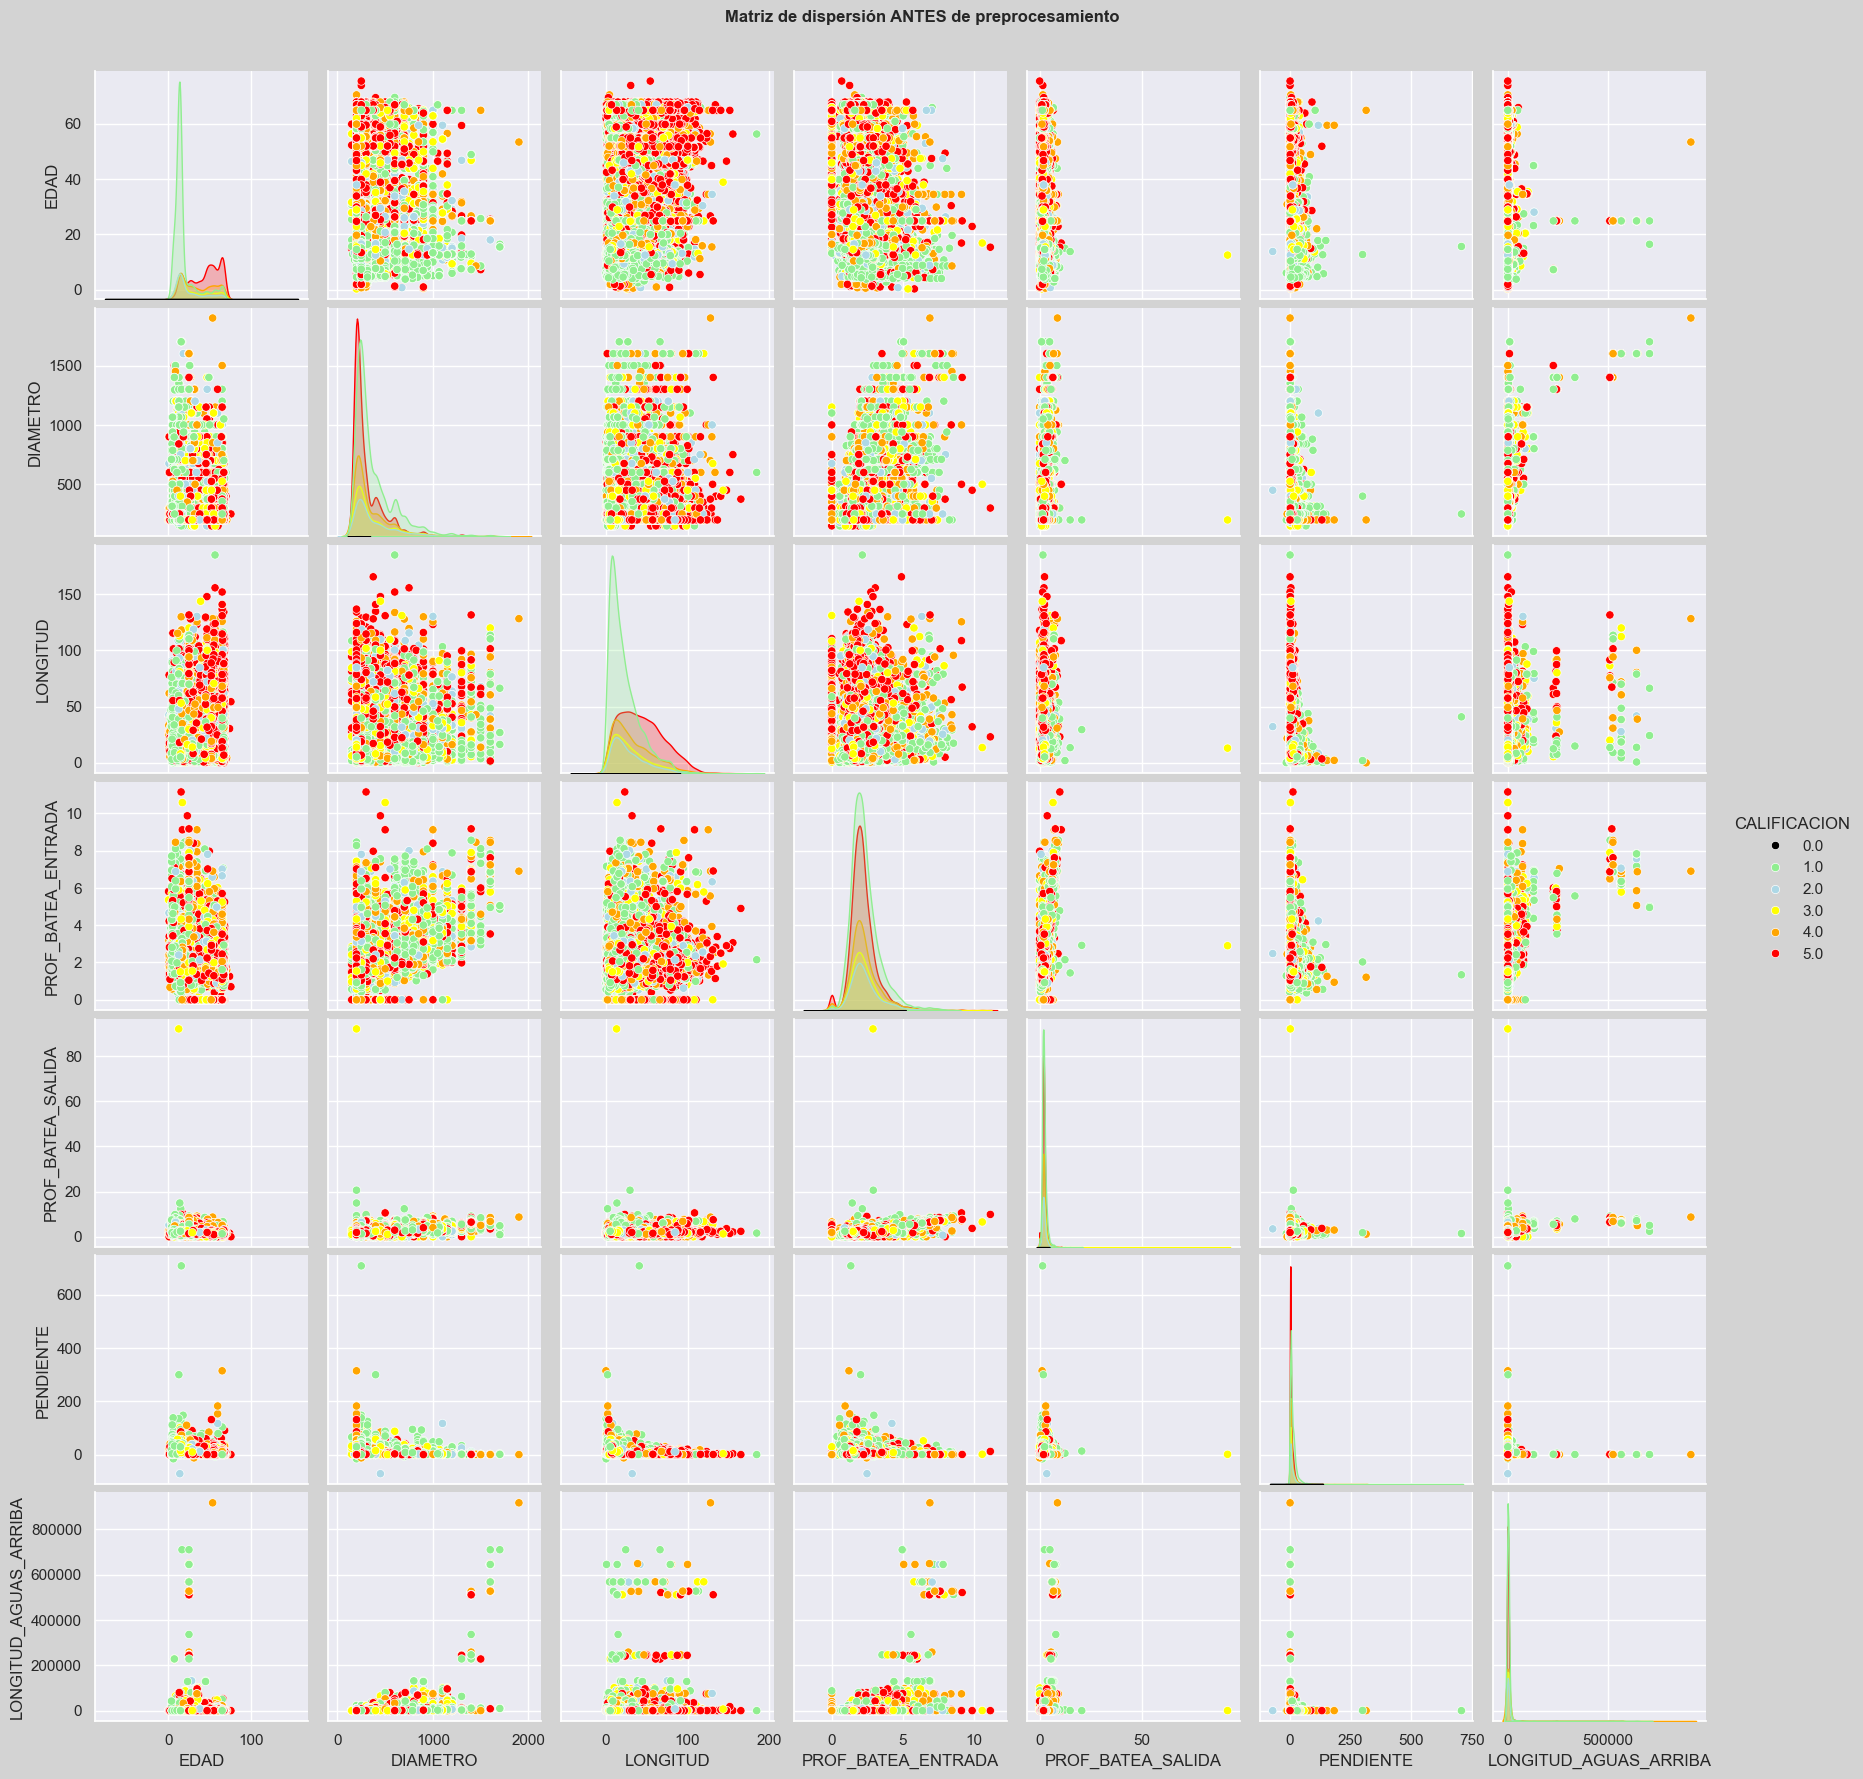

In [13]:
visualizar_matriz_dispersion(
    [c for c in numericas_a_explorar if c != 'CALIFICACION'],
    df_tramos_calificados_con_edad,
    nombre_columna_clasificadora='CALIFICACION',
    titulo='Matriz de dispersión ANTES de preprocesamiento'
)

## Variables categóricas

Conclusiones:

* TIPO_RED: Eliminar por mínima representación de categorías minoritarias y baja correlacion con CALIFICACION.
* TIPO_AGUA: Unificar categorias LLUVIAS y DESCARGAS.
* TIPO_CIMEN: Descartada, valores no estandarizados.
* TIPO_SUELO: Descartada, valores no estandarizados.
* MATERIAL: Unificar concreto simple, pvc. Incluir OTROS con concretos reforzados.
* FABRICANTE: MAntener los top-2 y unifcar los demás en "OTROS".
* CAMARA_CAI: Eliminar, tiene solamente dos categorías y el valor "SI" no esta suficientemente representado.
* ZONA: Reclasificar nulos en NORTE+N/D.
* MUNICIPIO: Reclasificar en MEDELLIN y los demás en OTROS.
* ESTADO: Descartada, clases minoritarias escasamente representadas.
* CALIFICACION: Binarizar convirtiendo a DETERIORADO, en donde 1-3 es False(Bueno, no deteriorado) y 4-5 es True(Deteriorado)

In [14]:
# Definir columnas categóricas para exploración inicial
categoricas_a_explorar = [
    'TIPO_RED',   'TIPO_AGUA',
    'TIPO_CIMENTACION', 'TIPO_SUELO',
    'MATERIAL',   'FABRICANTE',
    'ARRANQUE',   'CAMARA_CAIDA',
    'ZONA',       'MUNICIPIO',
    'ESTADO',
]

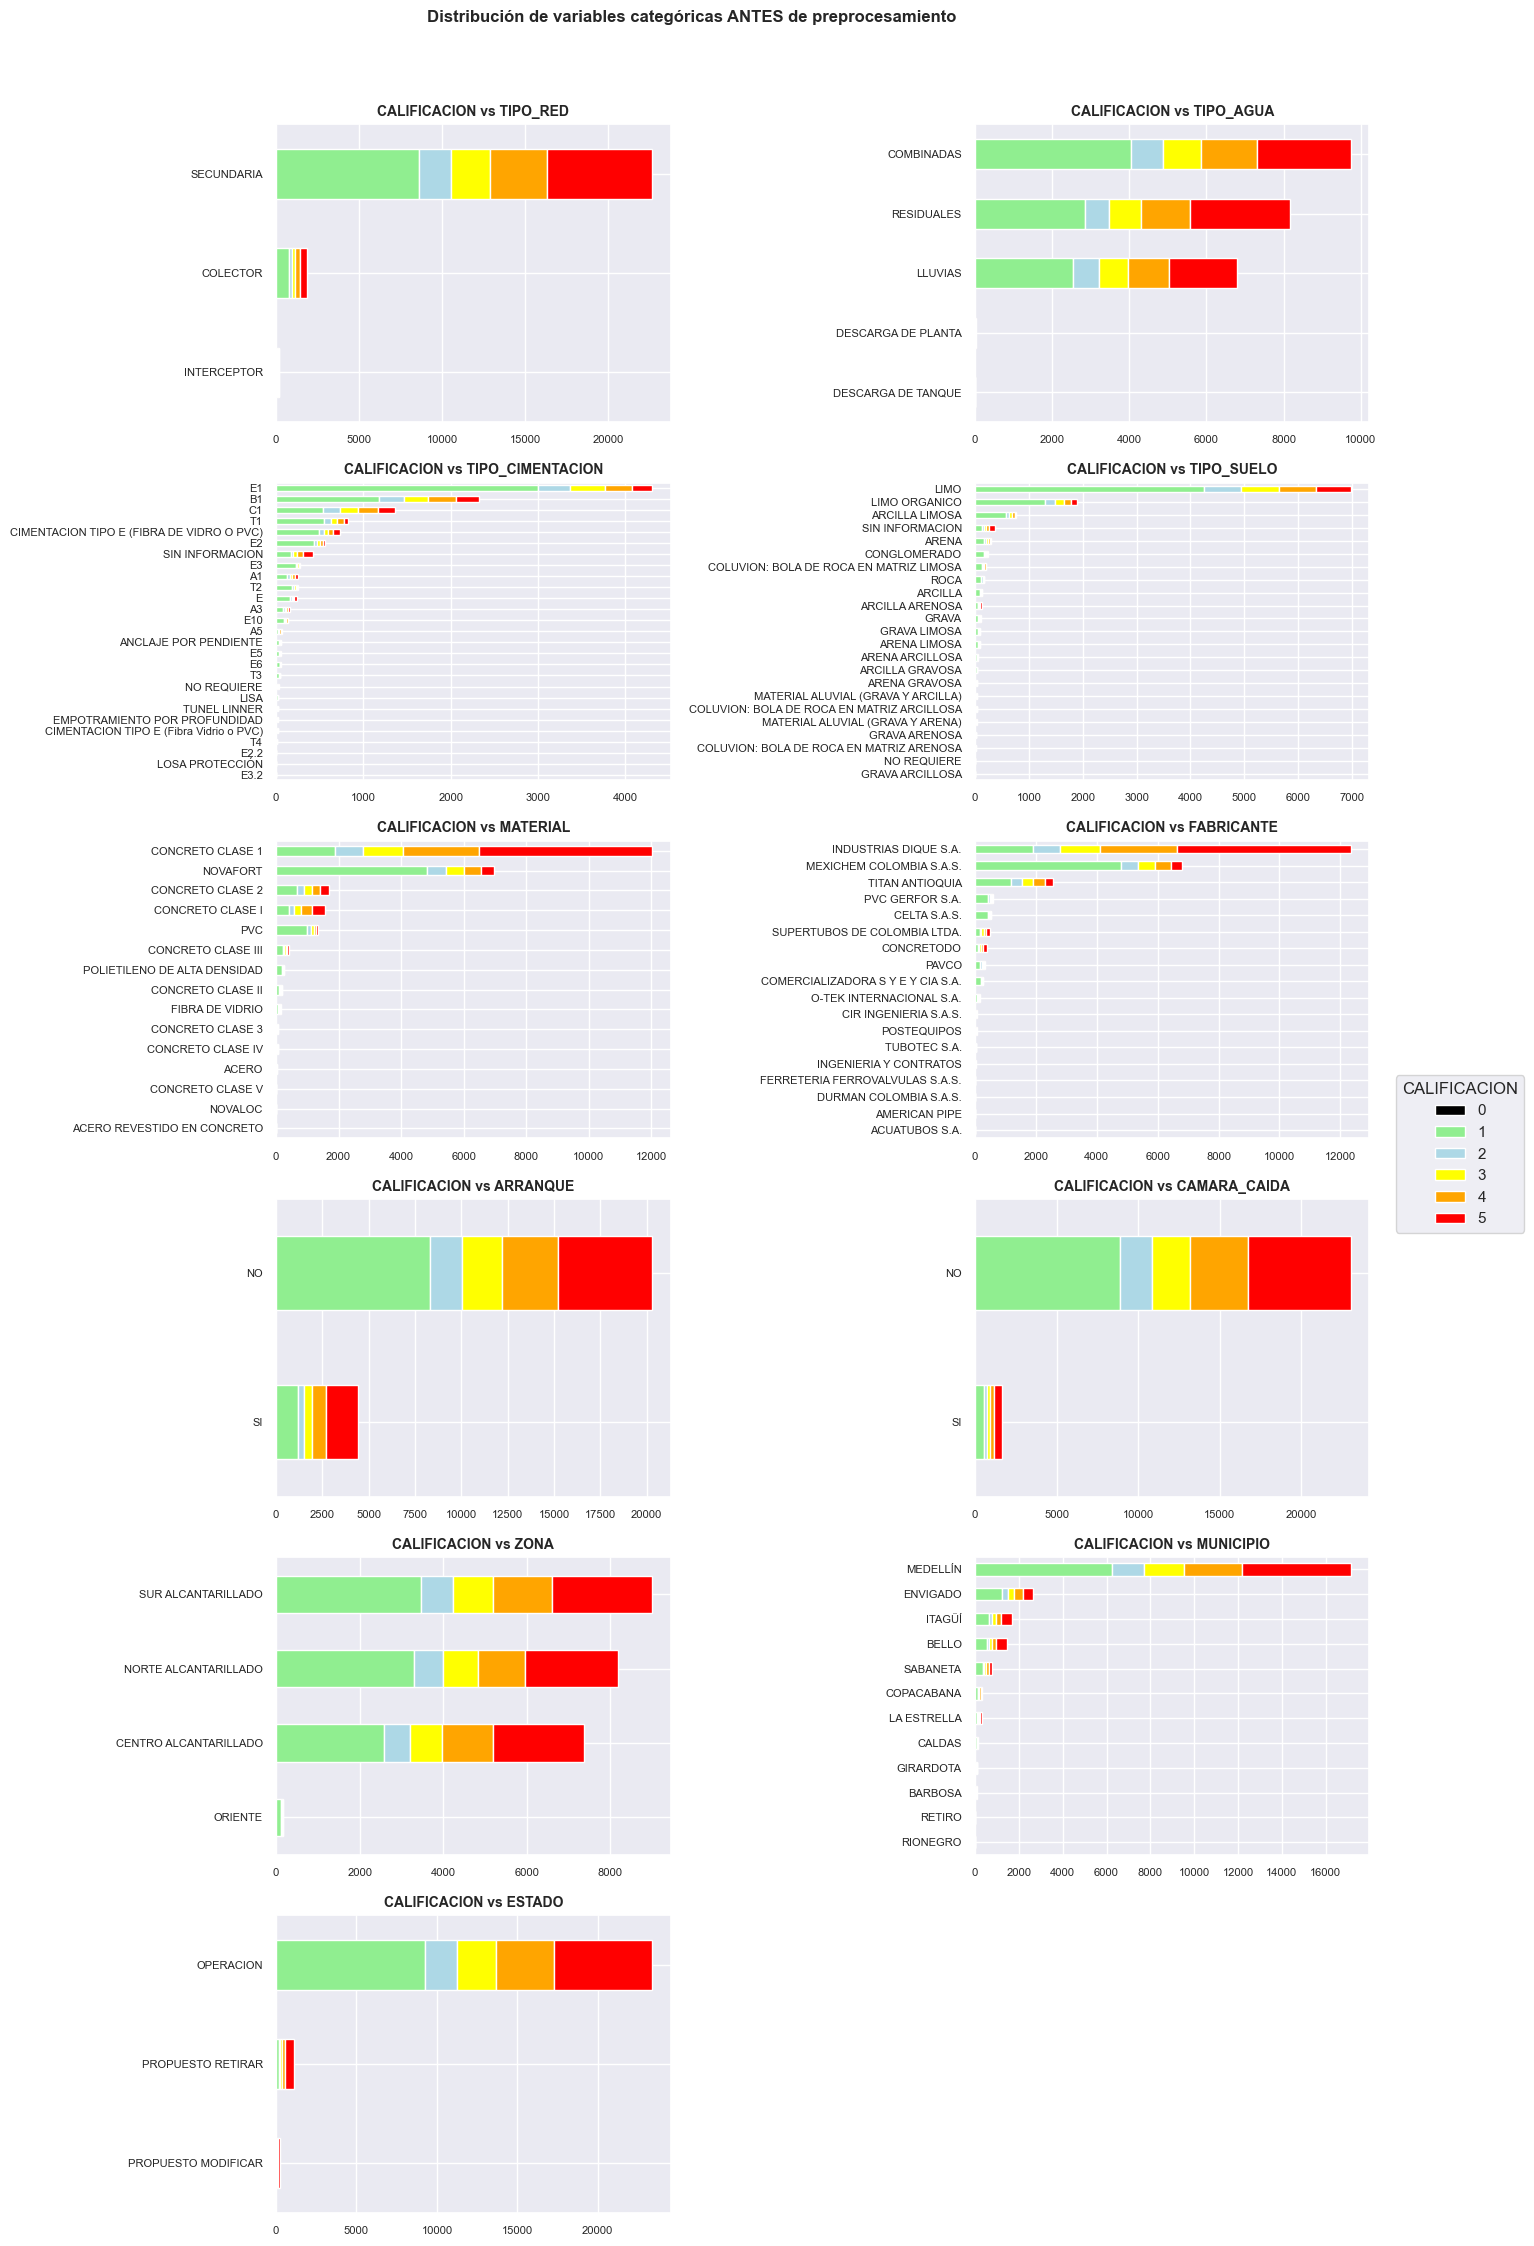

In [15]:
visualizar_distribucion_categoricas(
    categoricas_a_explorar,
    'CALIFICACION',
    df_tramos_calificados,
    titulo='Distribución de variables categóricas ANTES de preprocesamiento'
)

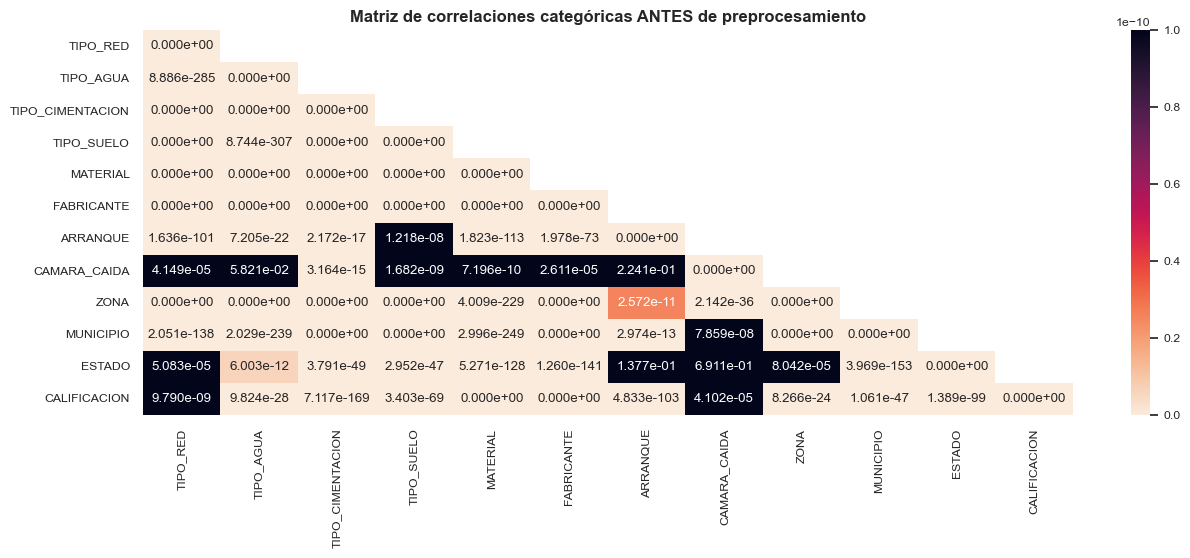

In [13]:
visualizar_correlaciones_categoricas(
    categoricas_a_explorar + ['CALIFICACION'],
    df_tramos_calificados,
    alpha=1e-10,
    titulo=f'Matriz de correlaciones categóricas ANTES de preprocesamiento'
)



---


# Operaciones de preprocesamiento


## Funciones de transformación

In [21]:
%run ../Lib/fn_transformaciones.py

Fecha y Hora de ejecución de módulo: 2024-10-30 09:25:38


## Secuencia de transformaciones

In [22]:
# Aplicar secuencia de operaciones
df_datos_preprocesados = tx_aplicar_transformaciones(df_tramos_calificados)

Aplicando transformación: Depurar datos nulos         ... Terminada.
Aplicando transformación: Convertir tipo de datos     ... Terminada.
Aplicando transformación: Validar rango de datos      ... Terminada.
Aplicando transformación: Unificar unidades a metros  ... Terminada.
Aplicando transformación: Reasignar arranque          ... Terminada.
Aplicando transformación: Reasignar tipo de agua      ... Terminada.
Aplicando transformación: Reasignar materiales        ... Terminada.
Aplicando transformación: Reasignar fabricantes       ... Terminada.
Aplicando transformación: Reasignar zonas             ... Terminada.
Aplicando transformación: Reasignar municipios        ... Terminada.
Aplicando transformación: Reasignar estados           ... Terminada.
Aplicando transformación: Agregar edad de tramos      ... Terminada.
Aplicando transformación: Aregar área de tramos       ... Terminada.
Aplicando transformación: Recalcular pendientes       ... Terminada.
Aplicando transformación: Binariza

In [23]:
df_datos_preprocesados.head()

DETERIORADO      EDAD  DIAMETRO  LONGITUD      AREA  PROF_BATEA_ENTRADA  PROF_BATEA_SALIDA  PENDIENTE   TIPO_AGUA         MATERIAL             FABRICANTE  ARRANQUE  ZONA_SUR  MUNICIPIO_MEDELLIN  ESTADO_OPERACION  LONGITUD_AGUAS_ARRIBA
0        False  0.037238  0.180177 -0.926141 -0.597378           -0.726697          -0.689720  -0.018305       OTRAS  CONCRETO SIMPLE  INDUSTRIAS DIQUE S.A.     False      True               False              True              -0.032291
1        False  0.037238  0.180177 -0.286292 -0.124305           -0.052050          -0.580119   0.152044       OTRAS  CONCRETO SIMPLE  INDUSTRIAS DIQUE S.A.     False      True               False              True              -0.033013
2         True  0.743936  1.103026  0.407640  1.013165            0.015415          -0.470518   0.016793  COMBINADAS  CONCRETO SIMPLE  INDUSTRIAS DIQUE S.A.     False      True               False              True              -0.115290
3        False  0.136542  0.641602 -1.029316 -0.627061           -0.283357          -0.121789  -0.152230  COMBINADAS  CONCRETO SIMPLE                  OTROS     False      True               False              True              -0.019992
4        False  0.406119 -0.742672  0.428442 -0.227962           -0.485751          -0.610010  -0.081395  COMBINADAS  CONCRETO SIMPLE  INDUSTRIAS DIQUE S.A.     False      True               False              True              -0.105763



---


## Revisión de datos preprocesados

In [24]:
print(df_datos_preprocesados.info())
print('-'*80)
print(df_datos_preprocesados.describe(include='all'))
# print('-'*80)
# print(df_datos_preprocesados.head())
# print('-'*80)

columnas_categoricas = list(df_datos_preprocesados.select_dtypes(include=['object', 'bool']).columns)
columnas_categoricas.remove('DETERIORADO')
columnas_numericas = list(df_datos_preprocesados.select_dtypes(include=['int', 'float']).columns)
# for columna in columnas_categoricas:
#     print('-' * 80)
#     print(columna)
#     print(df_datos_preprocesados[columna].value_counts())

# Encontrar columnas candidatas a binarización
# columnas_binarias = [col for col in columnas_categoricas if df_datos_preprocesados[col].nunique() == 2]
# print('-' * 80)
# print('Columnas categóricas con solamente dos categorias:')
# for col in columnas_binarias:
#     valores = df_datos_preprocesados[col].unique()
#     print(f'{col}: {valores}')

<class 'pandas.core.frame.DataFrame'>
Index: 22546 entries, 0 to 24999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DETERIORADO            22546 non-null  bool   
 1   EDAD                   22546 non-null  float64
 2   DIAMETRO               22546 non-null  float64
 3   LONGITUD               22546 non-null  float64
 4   AREA                   22546 non-null  float64
 5   PROF_BATEA_ENTRADA     22546 non-null  float64
 6   PROF_BATEA_SALIDA      22546 non-null  float64
 7   PENDIENTE              22546 non-null  float64
 8   TIPO_AGUA              22546 non-null  object 
 9   MATERIAL               22546 non-null  object 
 10  FABRICANTE             22546 non-null  object 
 11  ARRANQUE               22546 non-null  bool   
 12  ZONA_SUR               22546 non-null  bool   
 13  MUNICIPIO_MEDELLIN     22546 non-null  bool   
 14  ESTADO_OPERACION       22546 non-null  bool   
 15  LONGITU

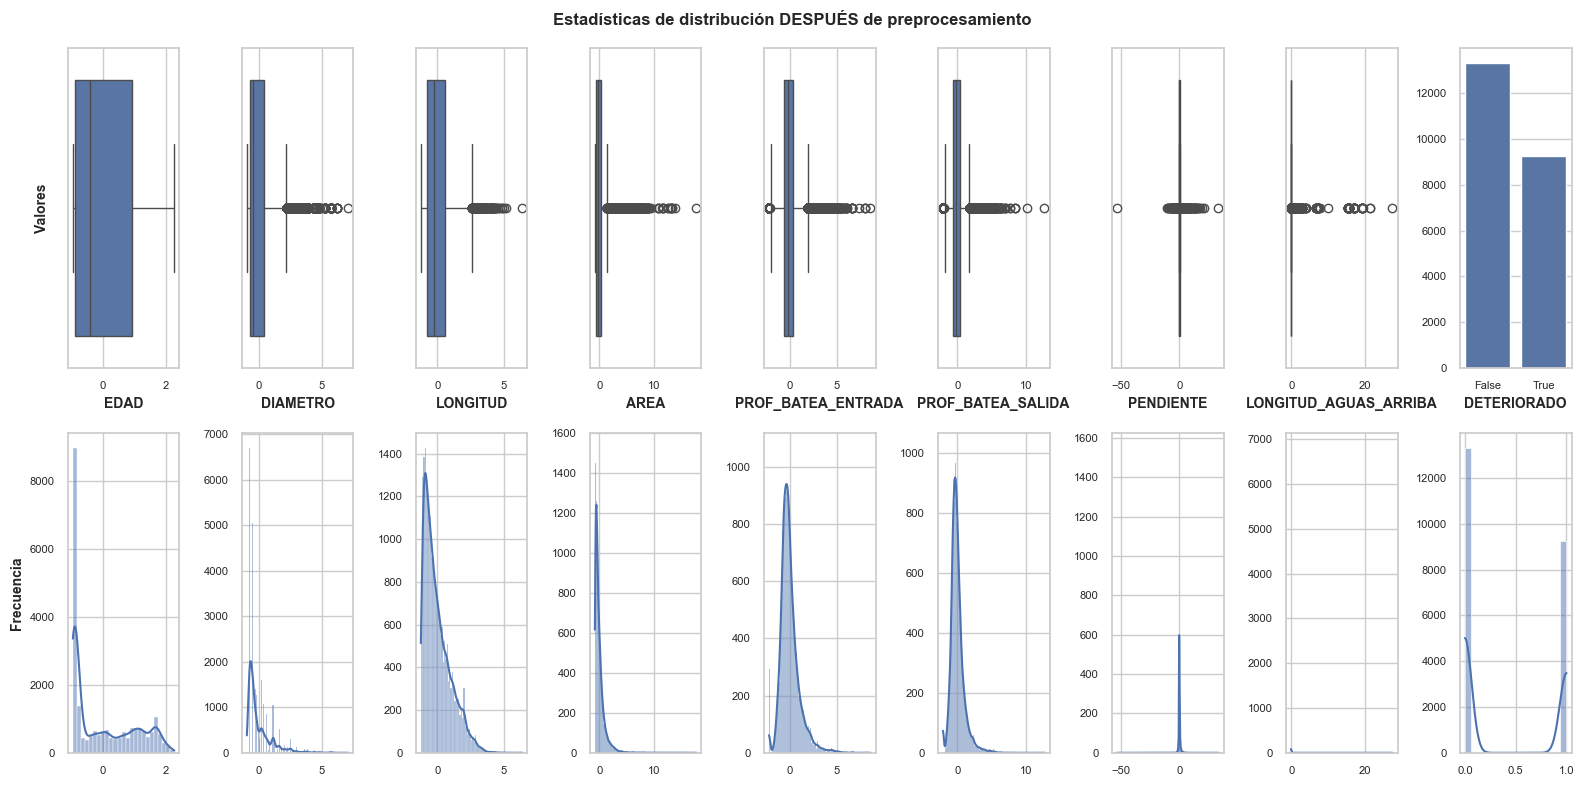

In [25]:
visualizar_distribucion(
    columnas_numericas + ['DETERIORADO'],
    df_datos_preprocesados,
    titulo='Estadísticas de distribución DESPUÉS de preprocesamiento'
)

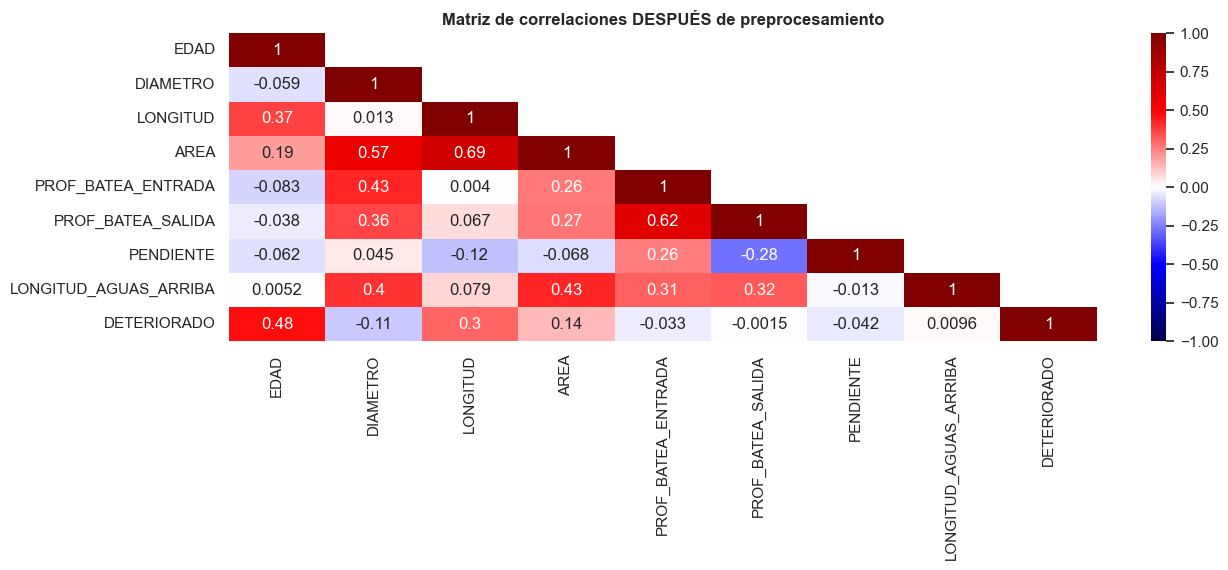

In [26]:
visualizar_correlaciones(
    columnas_numericas + ['DETERIORADO'],
    df_datos_preprocesados,
    titulo='Matriz de correlaciones DESPUÉS de preprocesamiento'
)

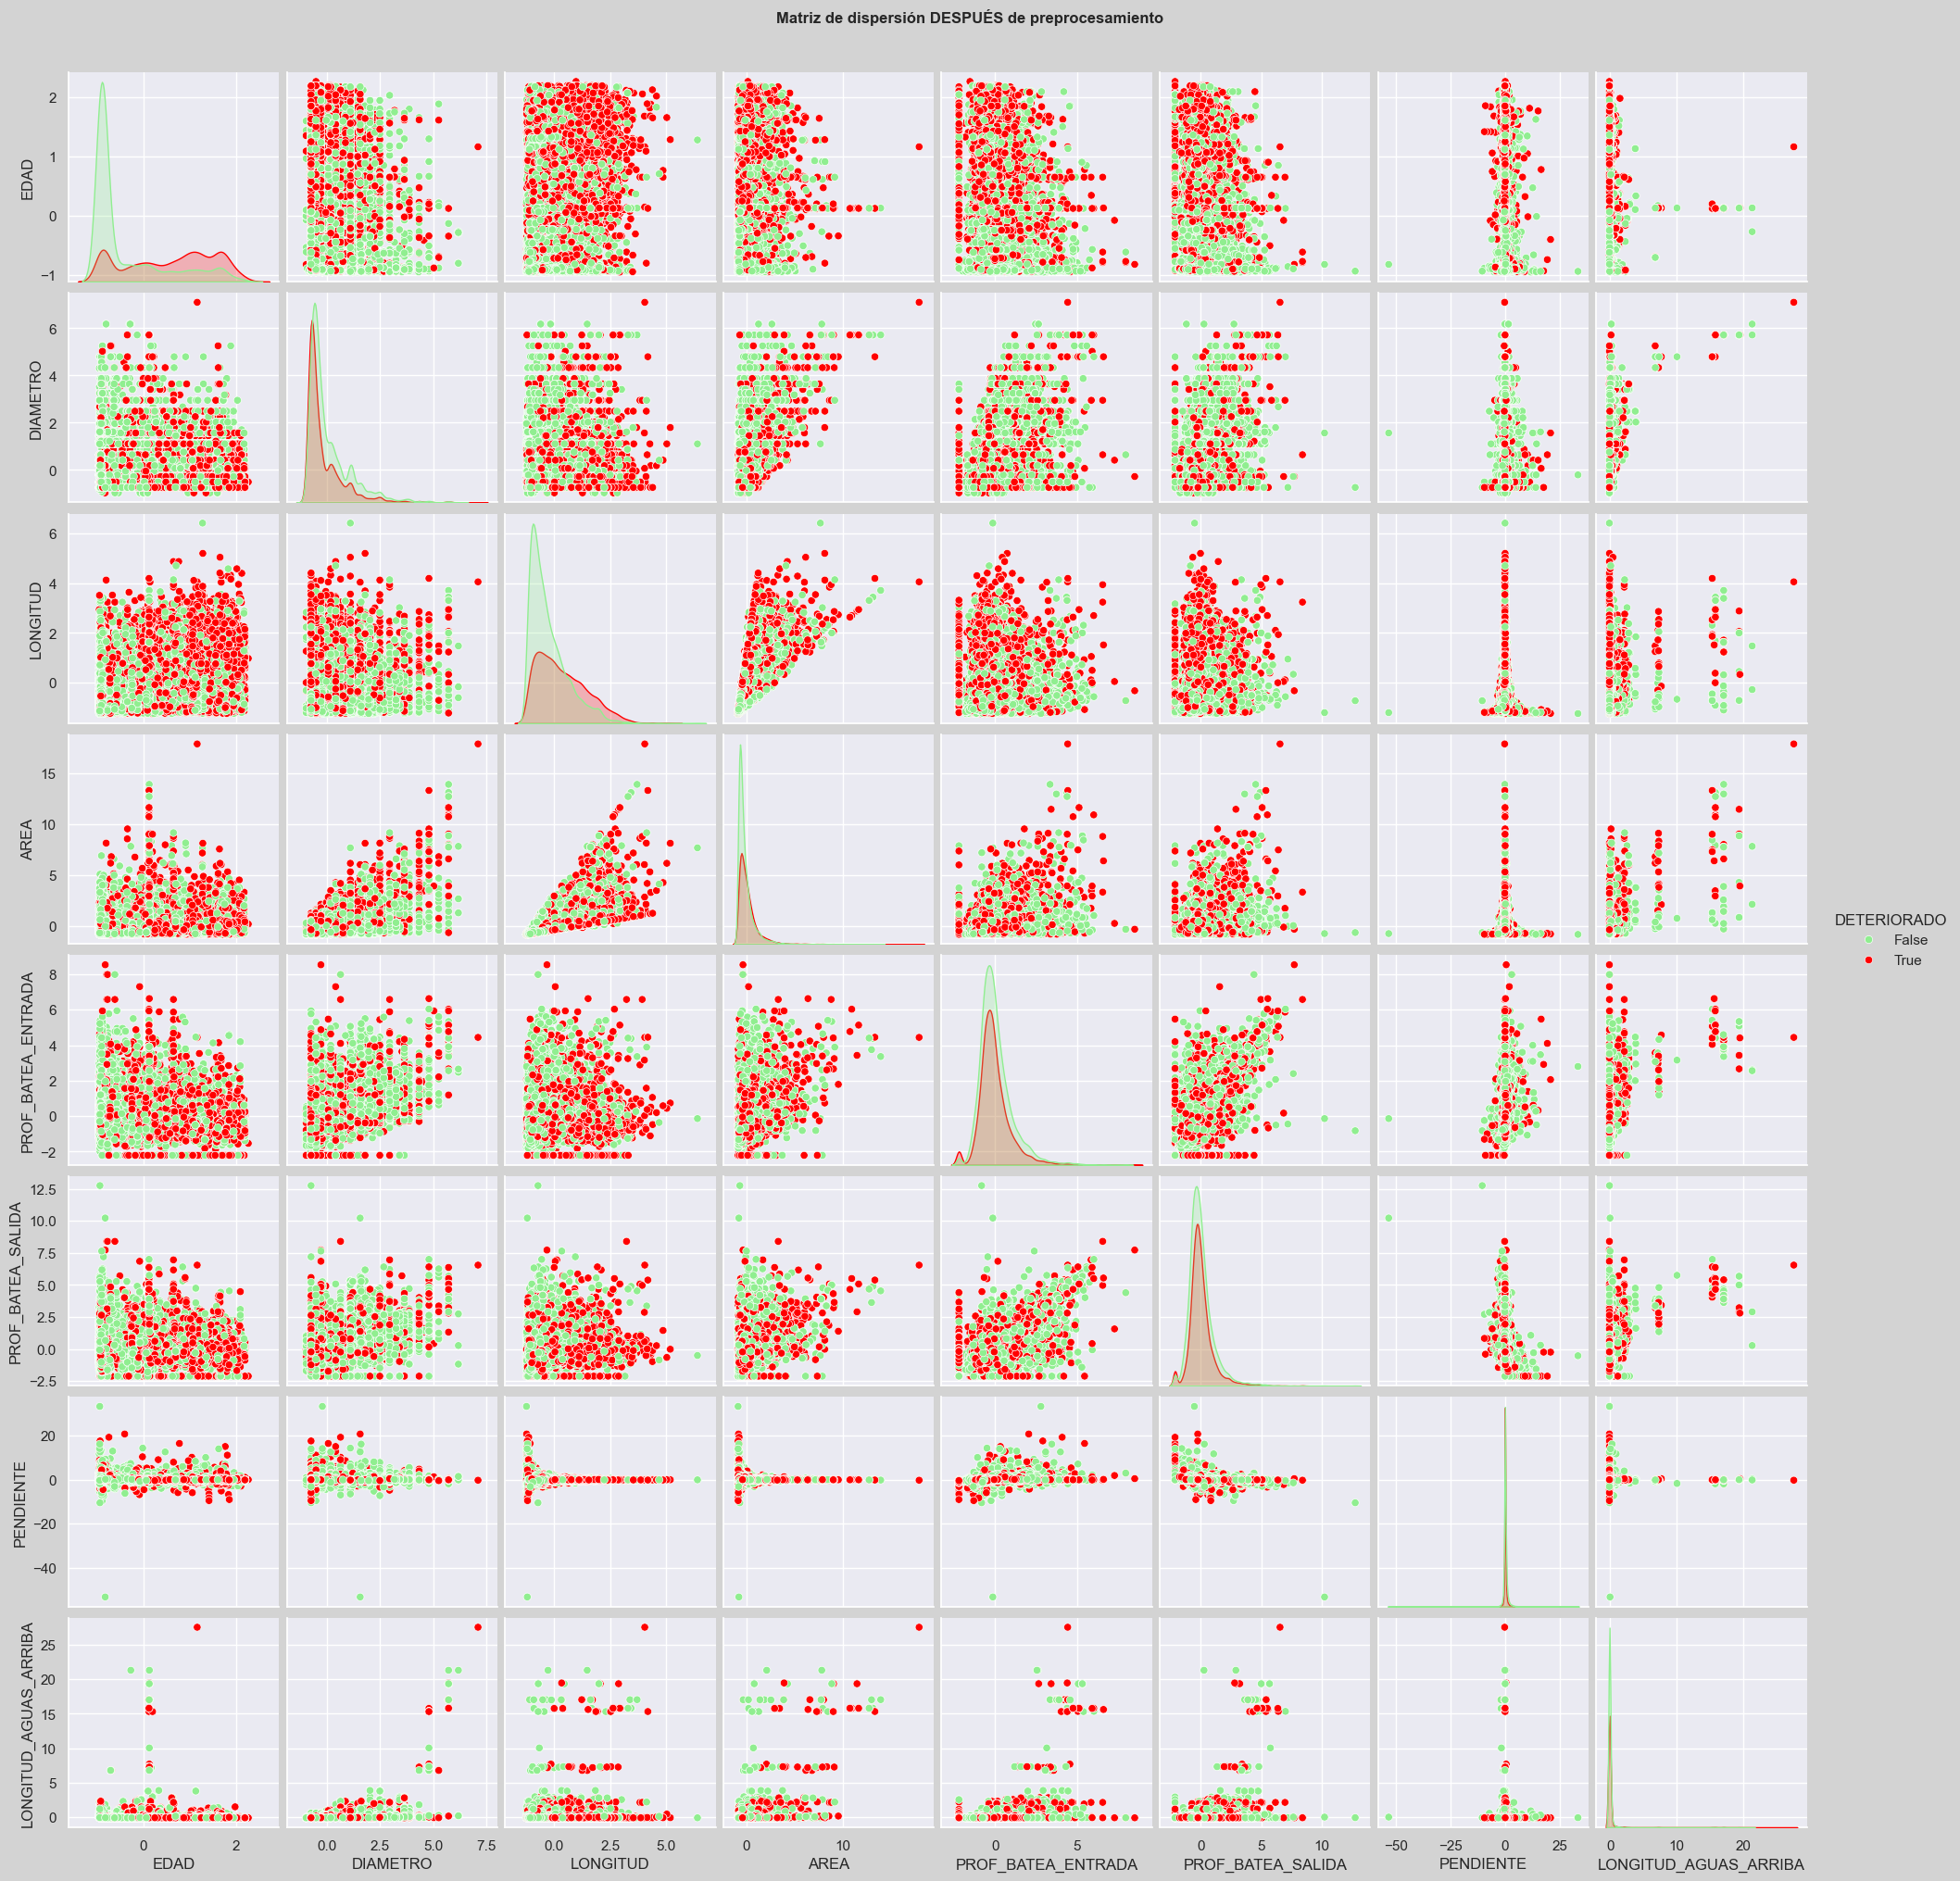

In [27]:
visualizar_matriz_dispersion(
    columnas_numericas,
    df_datos_preprocesados,
    nombre_columna_clasificadora='DETERIORADO',
    titulo='Matriz de dispersión DESPUÉS de preprocesamiento'
)

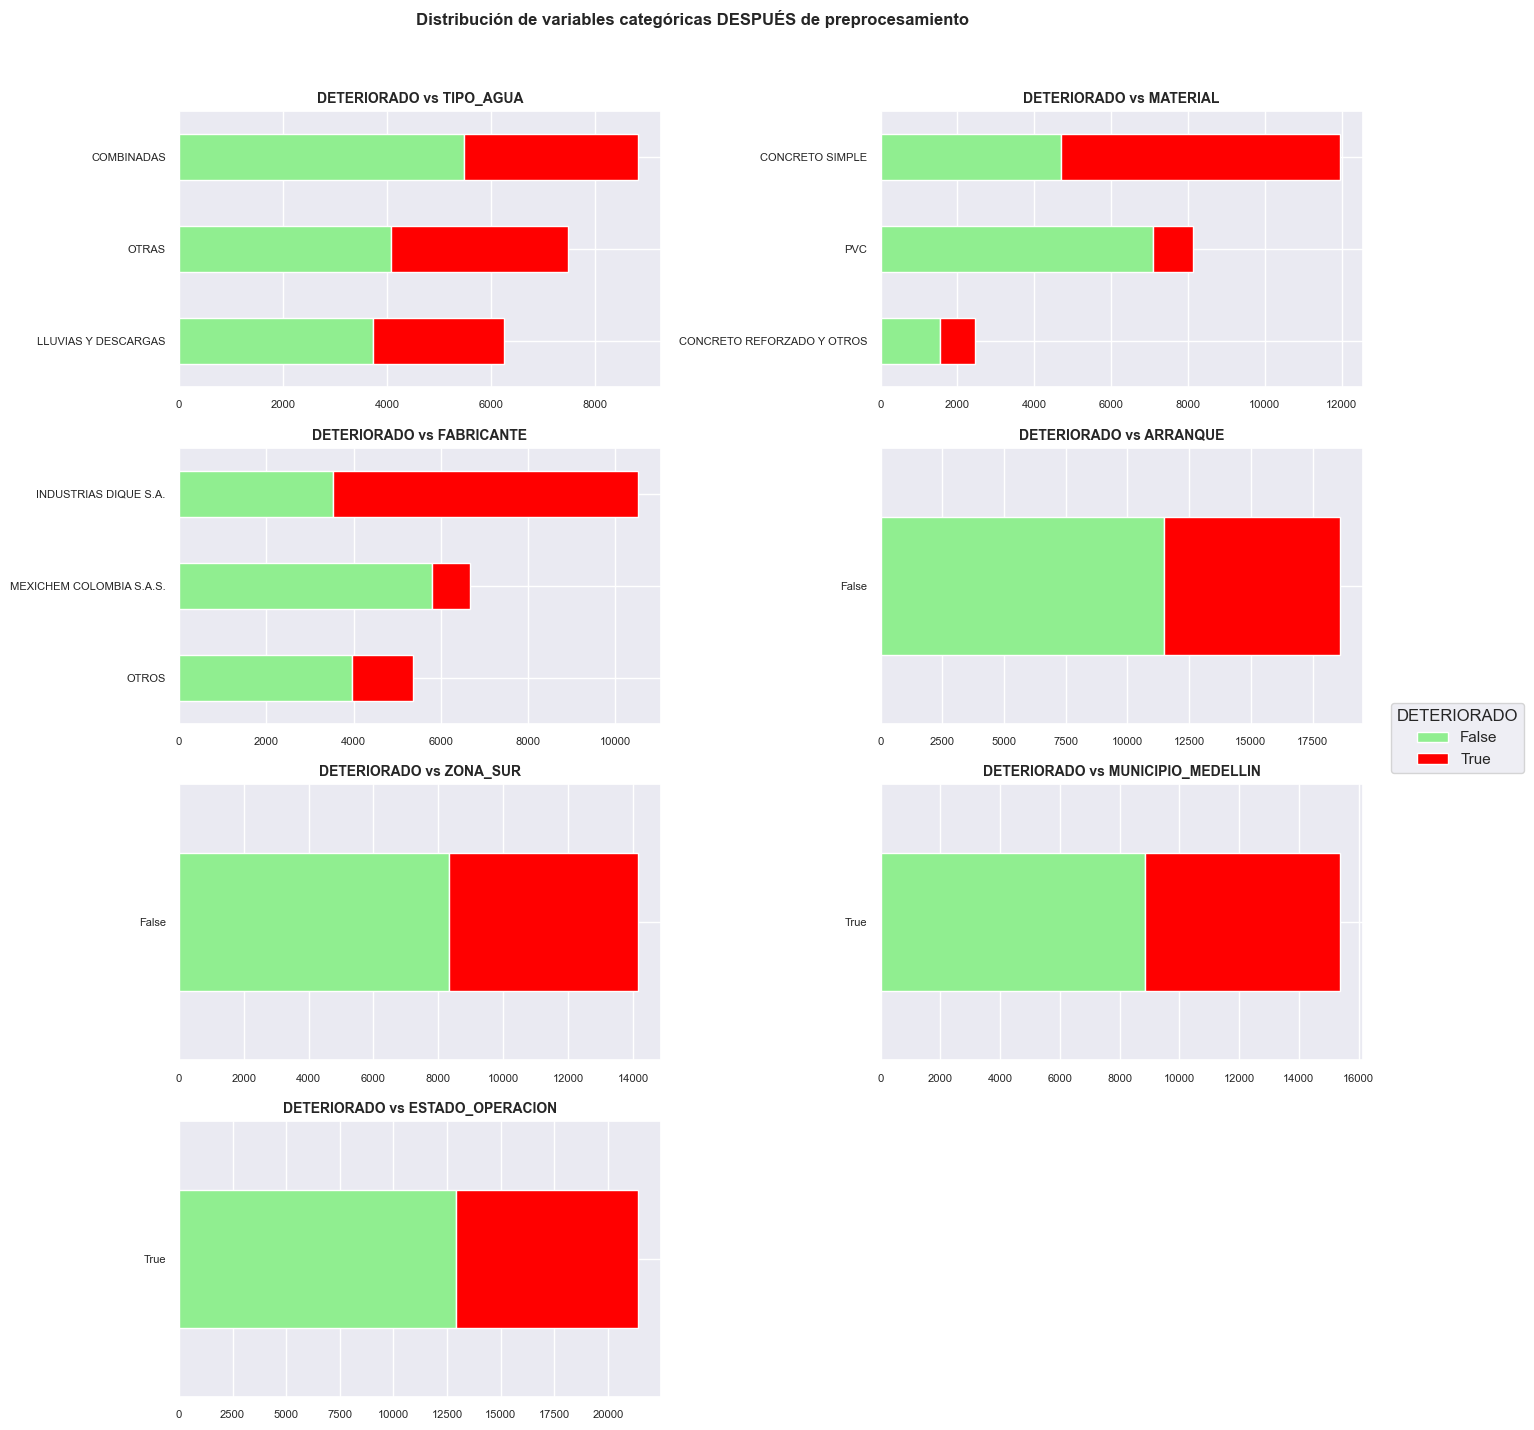

In [28]:
visualizar_distribucion_categoricas(
    columnas_categoricas,
    'DETERIORADO',
    df_datos_preprocesados,
    titulo='Distribución de variables categóricas DESPUÉS de preprocesamiento'
)

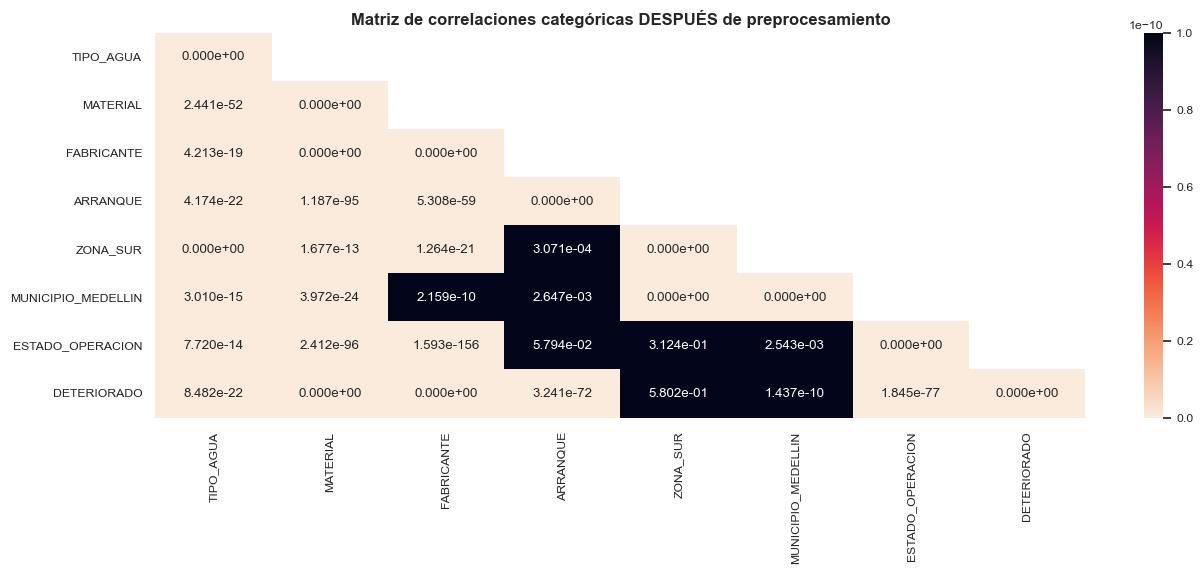

In [29]:
visualizar_correlaciones_categoricas(
    columnas_categoricas + ['DETERIORADO'],
    df_datos_preprocesados,
    alpha=1e-10,
    titulo=f'Matriz de correlaciones categóricas DESPUÉS de preprocesamiento'
)

# Codificación de datos

In [30]:
df_datos_codificados = tx_codificar(df_datos_preprocesados)
print(df_datos_codificados.info())

<class 'pandas.core.frame.DataFrame'>
Index: 22546 entries, 0 to 24999
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   DETERIORADO                          22546 non-null  bool   
 1   EDAD                                 22546 non-null  float64
 2   DIAMETRO                             22546 non-null  float64
 3   LONGITUD                             22546 non-null  float64
 4   AREA                                 22546 non-null  float64
 5   PROF_BATEA_ENTRADA                   22546 non-null  float64
 6   PROF_BATEA_SALIDA                    22546 non-null  float64
 7   PENDIENTE                            22546 non-null  float64
 8   ARRANQUE                             22546 non-null  bool   
 9   ZONA_SUR                             22546 non-null  bool   
 10  MUNICIPIO_MEDELLIN                   22546 non-null  bool   
 11  ESTADO_OPERACION                 

# Análisis de componentes principales - PCA

------------------------------------------------------------
k=2, dimensiones=(22546, 2)
[0.25966727 0.19168084]
------------------------------------------------------------
k=3, dimensiones=(22546, 3)
[0.25966727 0.19168084 0.11124115]
------------------------------------------------------------
k=4, dimensiones=(22546, 4)
[0.25966727 0.19168084 0.11124115 0.09812227]
------------------------------------------------------------
k=5, dimensiones=(22546, 5)
[0.25966727 0.19168084 0.11124115 0.09812227 0.07357158]
------------------------------------------------------------
k=6, dimensiones=(22546, 6)
[0.25966727 0.19168084 0.11124115 0.09812227 0.07357158 0.0650589 ]
------------------------------------------------------------
k=7, dimensiones=(22546, 7)
[0.25966727 0.19168084 0.11124115 0.09812227 0.07357158 0.0650589
 0.03830896]
------------------------------------------------------------
k=8, dimensiones=(22546, 8)
[0.25966727 0.19168084 0.11124115 0.09812227 0.07357158 0.0650589
 0

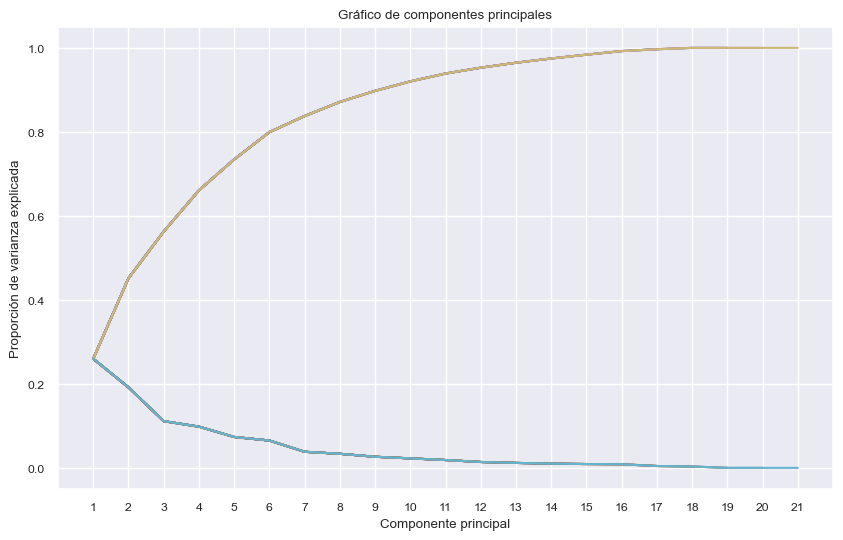

In [31]:
# Visualizar por metodo del codo.

X = df_datos_codificados.drop('DETERIORADO', axis='columns')
Y = df_datos_codificados['DETERIORADO']

plt.figure(figsize=(10, 6))
for k in range(2, X.shape[1]+1):
    pca = PCA(k)
    projected = pca.fit_transform(X)
    print('-'*60)
    print(f'k={k}, dimensiones={projected.shape}')
    print(pca.explained_variance_ratio_)
    PC_values = np.arange(pca.n_components_) + 1

    plt.plot(PC_values,np.cumsum(pca.explained_variance_ratio_))
    plt.plot(PC_values, pca.explained_variance_ratio_)

plt.title('Gráfico de componentes principales')
plt.xlabel('Componente principal')
plt.ylabel('Proporción de varianza explicada')
plt.xticks(PC_values)
plt.grid(True)
plt.show()

# Guardar datos preprocesados

In [32]:
archivo_datos_codificados = f'{DIRECTORIO_DATOS_PREPROCESADOS}/DATOSCODIFICADOS.csv'
df_datos_codificados.to_csv(archivo_datos_codificados, index=False)
print(f'Guardado {archivo_datos_codificados}')

Guardado ../Datos/Datos_preprocesados/DATOSCODIFICADOS.csv
